In [2]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Flatten, MaxPool2D, Conv2D, Dropout
from keras import optimizers
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

In [3]:
def load(test=False, cols=None):
    
    fname = 'data/test.csv' if test else 'data/training.csv'
    df = pd.read_csv(fname)

    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:
        df = df[list(cols) + ['Image']]

    print(df.count())
    df = df.dropna()

    X = np.vstack(df['Image'].values) / 255.
    X = X.astype(np.float32)

    if not test:
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48
        X, y = shuffle(X, y, random_state=42)
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

def load2d(test=False, cols=None):
    X, y = load(test=test)
    X = X.reshape(-1, 1, 96, 96)
    return X, y

In [4]:
def plotRun(run):
    plt.plot(run.history['loss'], label='train')
    plt.plot(run.history['val_loss'], label='test')
    plt.legend()
    plt.show()

In [5]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

def showSample(model, fname, twod = False):
    if twod:
        X, _ = load2d(test=True)
    else:
        X, _ = load(test=True)
    y_pred = model.predict(X)

    fig = plt.figure(figsize=(6, 6))
    fig.subplots_adjust(
        left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(16):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        plot_sample(X[i], y_pred[i], ax)
    plt.savefig(fname)
    plt.show()

In [6]:
x, y = load()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [7]:
def makeNet():
    net = Sequential()
    net.add(Dense(500, input_dim=9216, activation='relu', kernel_initializer='glorot_uniform'))
    net.add(Dropout(0.50))
    net.add(Dense(100, activation='relu', kernel_initializer='glorot_uniform'))
    net.add(Dropout(0.40))
    net.add(Dense(100, activation='relu', kernel_initializer='glorot_uniform'))
    net.add(Dropout(0.30))
    net.add(Dense(400, activation='relu', kernel_initializer='glorot_uniform'))
    net.add(Dropout(0.20))
    net.add(Dense(30, activation='linear', kernel_initializer='glorot_uniform'))
    sgd = optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    net.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mse'])
    return net

Epoch 00100: early stopping


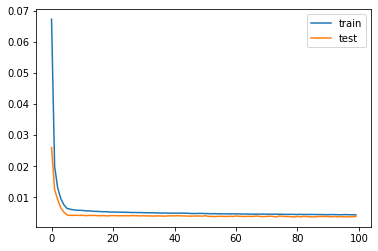

In [8]:
net1 = makeNet()
es = EarlyStopping(monitor='val_loss', verbose=1, patience=20)
mc = ModelCheckpoint('models/best_model_nn.h5', monitor='val_loss', verbose=0, save_best_only=True)
run = net1.fit(x,y, validation_split=0.05, epochs=100, verbose=0, callbacks= [mc,es])
plotRun(run)

In [9]:
print('best validation: {}'.format(run.history['val_loss'][-1]))
print('kaggle score: {}'.format(np.sqrt(run.history['val_loss'][-1])*48))

best validation: 0.003912765067070723
kaggle score: 3.0025007434688415


ImageId    1783
Image      1783
dtype: int64


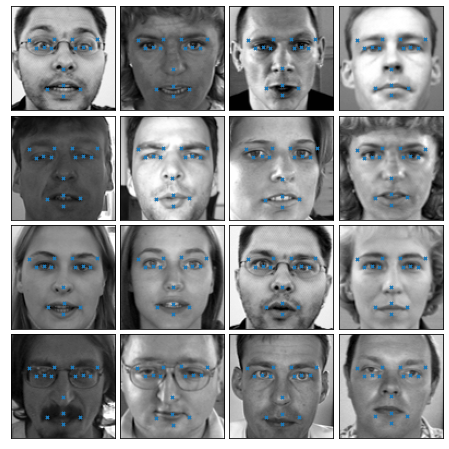

In [10]:
bestModel = load_model('models/best_model_nn.h5')
showSample(bestModel, 'imgs/nn.png')

In [11]:
x2, y2 = load2d()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [12]:
def makeCNN(dropout=False):
    cnn = Sequential()
    cnn.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(1, 96, 96), data_format='channels_last', padding="same"))
    if dropout:
        cnn.add(Dropout(0.1))
    cnn.add(MaxPool2D(pool_size=2, padding="same"))
    cnn.add(Conv2D(64, kernel_size=3, activation='relu', padding="same"))
    if dropout:
        cnn.add(Dropout(0.15))
    cnn.add(MaxPool2D(pool_size=2, padding="same"))
    cnn.add(Conv2D(128, kernel_size=3, activation='relu', padding="same"))
    if dropout:
        cnn.add(Dropout(0.2))
    cnn.add(MaxPool2D(pool_size=2, padding="same"))
    cnn.add(Flatten())
    cnn.add(Dense(500, kernel_initializer='glorot_uniform', activation='relu'))
    if dropout:
        cnn.add(Dropout(0.5))
    cnn.add(Dense(500, kernel_initializer='glorot_uniform', activation='relu'))
    if dropout:
        cnn.add(Dropout(0.5))
    cnn.add(Dense(30, kernel_initializer='glorot_uniform', activation='linear'))
    cnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
    return cnn

Epoch 00157: early stopping


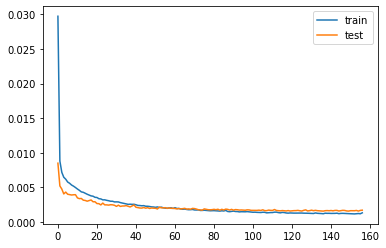

In [13]:
cnn = makeCNN(dropout=True)
es = EarlyStopping(monitor='val_loss', verbose=1, patience=20)
mc = ModelCheckpoint('models/best_model_cnn.h5', monitor='val_loss', verbose=0, save_best_only=True)
run = cnn.fit(x2,y2, validation_split=0.3, epochs=400, verbose=0, callbacks= [mc,es])
plotRun(run)

In [14]:
print('best validation: {}'.format(run.history['val_loss'][-1]))
print('kaggle score: {}'.format(np.sqrt(run.history['val_loss'][-1])*48))

best validation: 0.0017120130360126495
kaggle score: 1.9860710045144772


ImageId    1783
Image      1783
dtype: int64


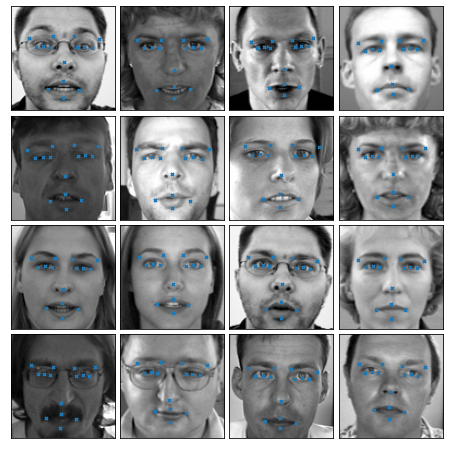

In [15]:
bestModel = load_model('models/best_model_cnn.h5')
showSample(bestModel, 'imgs/cnn.png', twod=True)